# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from PIL import Image

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
print('Размер исходного датасета:',labels.shape)

Размер исходного датасета: (7591, 2)


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


**Вывод**

Объем исходного датасета недостаточно большой, можем столкнуться с проблемой недообучения. Увеличим выборку применив горизонтальное отражение изображений.

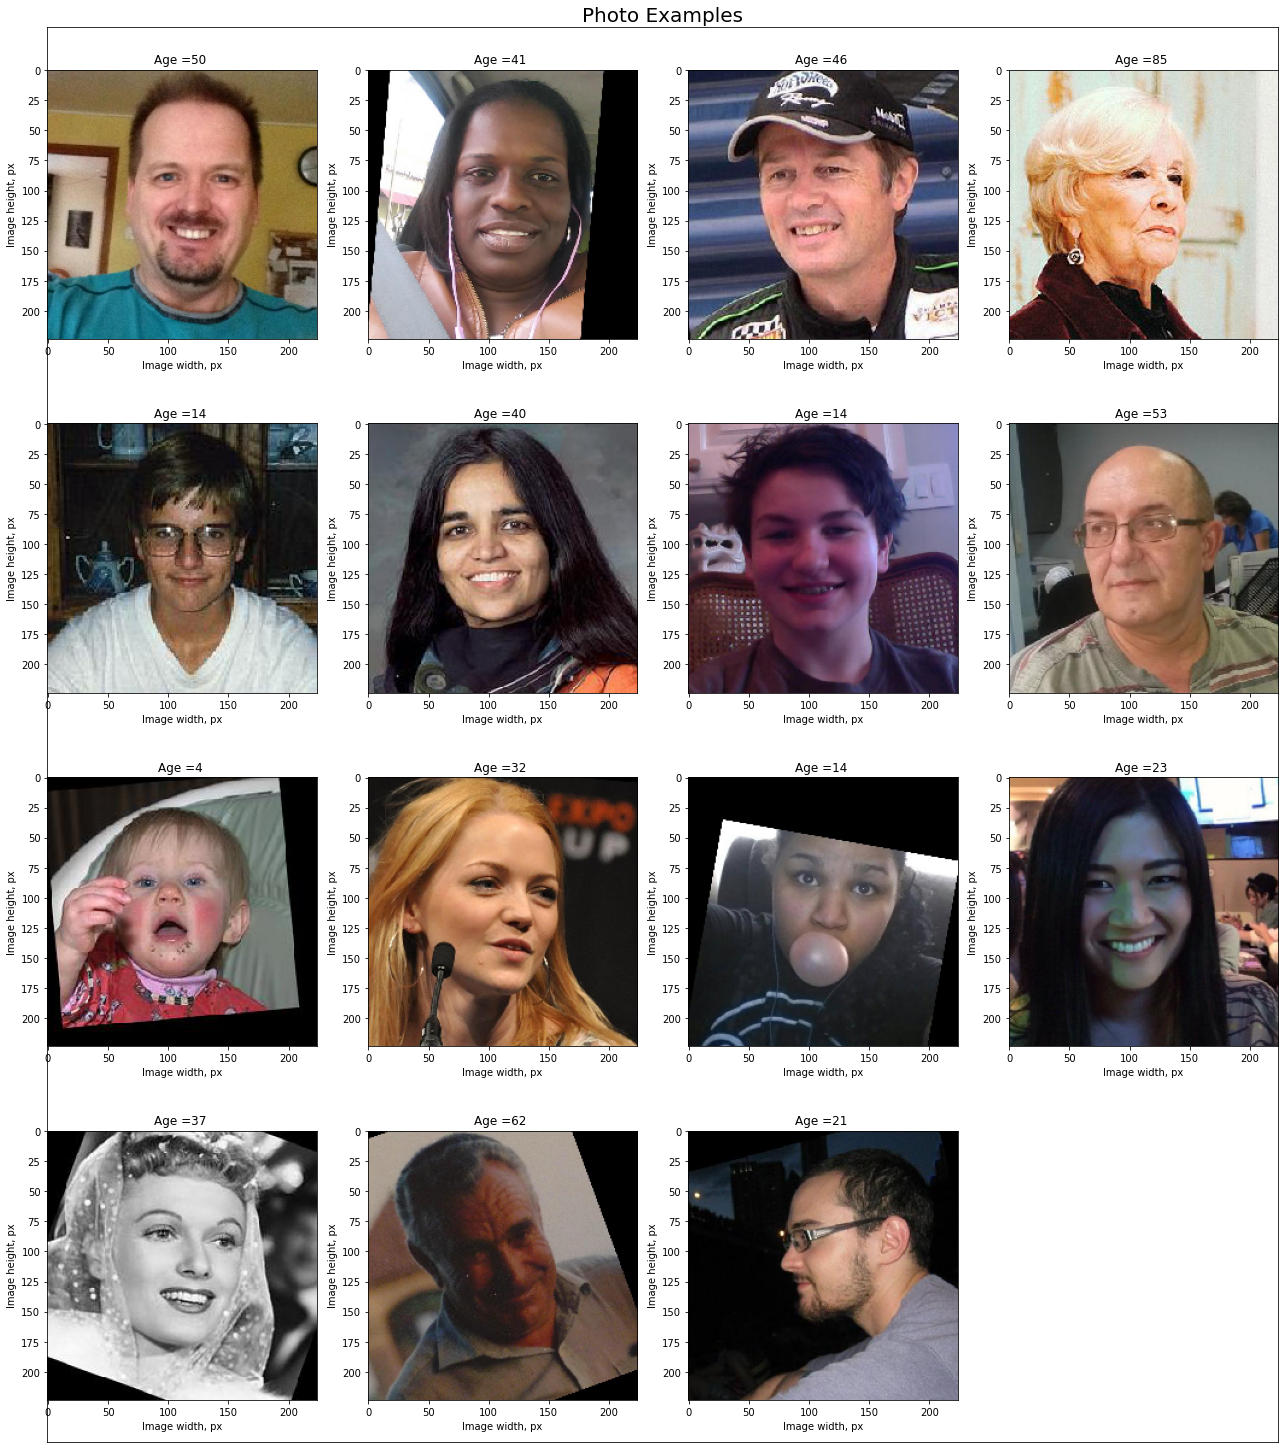

In [5]:
features, target = next(train_gen_flow)

# выводим 15 изображений

fig = plt.figure(figsize=(18,20))
plt.title('Photo Examples', {'fontsize': 20,
 'fontweight' : 10,
 'verticalalignment': 'baseline'})
plt.xticks([])
plt.yticks([])
plt.tight_layout()
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.tight_layout() 
    plt.title('Age ={} '.format(target[i]), loc='center')    
    plt.xlabel('Image width, px')
    plt.ylabel('Image height, px')

In [6]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


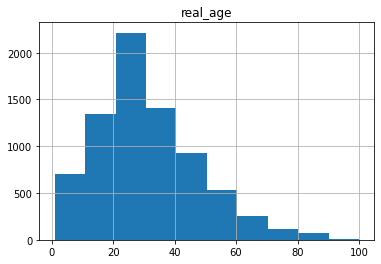

In [7]:
labels.hist();

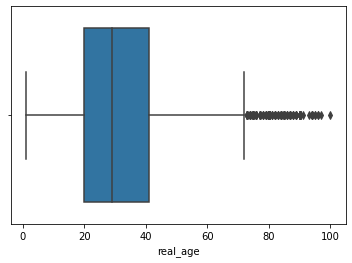

In [8]:
sns.boxplot(x=labels.real_age);

- Гистограмма имеет нормальное распределение, смещенное вправо;
- В данных имеются выбросы. Выбросы тут могут быть связаны с тем, что настоящий возраст был неизвестен тому, кто размечал датасет, и он его попросту округлял до "юбилейных" лет. Поэтому, некоторые "круглые" года в датасете некорректные. Удалять их в нашем проекте нет необходимости. Возраста старше 70 лет не являются выбросами, т.к. это вполне реальные люди и удалять их не следует;
- Из гистограммы распределения возраста можно видеть, что большинство людей на снимках в возрасте 25-35 лет, меньше всего с 70-100;

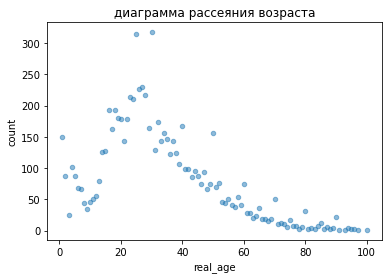

In [9]:
data = labels.pivot_table(index='real_age', values='file_name', aggfunc='count').reset_index()
data.plot(kind='scatter', x='real_age', y='file_name', alpha=.5).set(title='диаграмма рассеяния возраста', ylabel='count');

**Вывод**

- В данных представлены снимки людей различного пола и возраста;
- Палитра исходных изображений - оттенки серого, RGB; 
- Ориентация фотографий различна, при этом все снимки одного размера.

## Обучение модели

```python

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd

def load_train(path):
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       rescale=1./255,
                                       horizontal_flip=True)

    labels = pd.read_csv(path + 'labels.csv')
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                            directory=path + 'final_files/',
                                                            x_col='file_name',
                                                            y_col='real_age',
                                                            target_size=(224, 224),
                                                            batch_size=32,
                                                            class_mode='raw',
                                                            subset='training',
                                                            seed=12345)

    return (train_datagen_flow)

def load_test(path):
    test_datagen = ImageDataGenerator(validation_split=0.25,
                                      rescale=1./255)

    labels = pd.read_csv(path + 'labels.csv')
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
                                                            directory=path + 'final_files/',
                                                            x_col='file_name',
                                                            y_col='real_age',
                                                            target_size=(224, 224),
                                                            batch_size=32,
                                                            class_mode='raw',
                                                            subset='validation',
                                                            seed=12345)
    return (test_datagen_flow)

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=6,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              batch_size=batch_size,
              validation_data=test_data,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/6
178/178 - 47s - loss: 248.8223 - mae: 11.1393 - val_loss: 843.6320 - val_mae: 24.1606
Epoch 2/6
178/178 - 38s - loss: 76.0648 - mae: 6.6646 - val_loss: 753.1299 - val_mae: 22.4291
Epoch 3/6
178/178 - 38s - loss: 51.3397 - mae: 5.4455 - val_loss: 413.5788 - val_mae: 15.2793
Epoch 4/6
178/178 - 38s - loss: 38.0251 - mae: 4.7028 - val_loss: 126.2700 - val_mae: 8.4500
Epoch 5/6
178/178 - 37s - loss: 29.0199 - mae: 4.1113 - val_loss: 83.6032 - val_mae: 6.8823
Epoch 6/6
178/178 - 37s - loss: 21.2284 - mae: 3.5501 - val_loss: 69.3579 - val_mae: 6.1638
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 69.3579 - mae: 6.1638
Test MAE: 6.1638
```

## Анализ обученной модели

Используя архитектуру *ResNet50*, была построена модель, которая по фотографии определяет приблизительный возраст человека. 

- Размер исходного датасета: 7591 изображений;   
- Размер снимков (224, 224);
- Изображения были приведены к диапазону [0, 1];
- К исходным данным был применен горизонтальный флип, таким образом размер исходного датасета увеличился в два раза;
- Размер вадидационной выборки составляет 25% от тренировочной;
- Количество изображений в батче – 32; 
- Обучение модели проходит в 6 эпох.
Данная модель включает 50 слоев, 48 из которых это комбинация сверточных слоев с пуллингом предобученные на данных *ImageNet*.

Два последних слоя:
- average пуллинг, размер ядра равен размеру входного слоя;
- полносвязный слой с одним нейроном и функцией активации *ReLu*, поскольку решается задача регрессии. Для оптимизации использовался алгоритм *Adam*, скорость обучения $10^{-4}$, метрика MAE, функция потерь MSE.

Качество обученной модели было рассчитано с помощью метрики *MAE = 6.1638*. 

Полученная модель позволяет анализировать покупки и предлагать товары, которые могут заинтересовать покупателей определенной возрастной группы. Однако ошибка предсказания возраста слишком велика, чтобы контролировать добросовестность кассиров при продаже алкоголя.




## Чек-лист

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [ ]  MAE модели не больше 8
- [ ]  Код обучения модели скопирован в финальную тетрадь
- [ ]  Результат вывода модели на экран перенесён в финальную тетрадь
- [ ]  По итогам обучения модели сделаны выводы